In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)
#data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]

data.shape
data.head(2)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(511, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;__,10611.0,247.0,699.0,1819.0,421.0,194.0,2550.0,9995.0,7853.0,1220.0,...,0.0,0.0,0.0,0.0,0.0,23.0,4733.0,16.0,116.0,99.0
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptostreptococcaceae;__,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data = data/data.sum()*100

In [4]:
genus = [i for i in data.index if i[-1]!='_']

In [5]:
def get_Enterotype(data, k, ncluster_path, pca_path, rm_percent=0.1):
    ### rpy2
    import rpy2.robjects as ro
    from rpy2.robjects import r, pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.pandas2ri import py2rpy, rpy2py
    pandas2ri.activate()
    importr('cluster')
    importr('clusterSim')
    importr('ade4')
    
    _ = r.assign('data', data)
    _ = r('''
    #Function 1
    dist.JSD <- function(inMatrix, pseudocount=0.000001, ...) {
        KLD <- function(x,y) sum(x *log(x/y))
        JSD<- function(x,y) sqrt(0.5 * KLD(x, (x+y)/2) + 0.5 * KLD(y, (x+y)/2))
        matrixColSize <- length(colnames(inMatrix))
        matrixRowSize <- length(rownames(inMatrix))
        colnames <- colnames(inMatrix)
        resultsMatrix <- matrix(0, matrixColSize, matrixColSize)

      inMatrix = apply(inMatrix,1:2,function(x) ifelse (x==0,pseudocount,x))

        for(i in 1:matrixColSize) {
            for(j in 1:matrixColSize) { 
                resultsMatrix[i,j]=JSD(as.vector(inMatrix[,i]),
                as.vector(inMatrix[,j]))
            }
        }
        colnames -> colnames(resultsMatrix) -> rownames(resultsMatrix)
        as.dist(resultsMatrix)->resultsMatrix
        attr(resultsMatrix, "method") <- "dist"
        return(resultsMatrix) 
     }

    pam.clustering=function(x,k) { # x is a distance matrix and k the number of clusters
                             require(cluster)
                             cluster = as.vector(pam(as.dist(x), k, diss=TRUE)$clustering)
                             return(cluster)
                            }

    noise.removal <- function(dataframe, percent=0.01, top=NULL){
        dataframe->Matrix
        bigones <- rowSums(Matrix)*100/(sum(rowSums(Matrix))) > percent 
        Matrix_1 <- Matrix[bigones,]
        #print(percent)
        return(Matrix_1)
     }
    ''')
    _ = r("data.dist=dist.JSD(data)")
    _ = r('pdf("'+ncluster_path+'")')
    _ = r('''
    nclusters=NULL

    for (k in 1:10) { 
        if (k==1) {
            nclusters[k]=NA 
        } else {
            data.cluster_temp=pam.clustering(data.dist, k)
            nclusters[k]=index.G1(t(data),data.cluster_temp,  d = data.dist,
            centrotypes = "medoids")
        }
    }
    plot(nclusters, type="h", xlab="k clusters", ylab="CH index")
    dev.off();
    ''')
    r("data.cluster=pam.clustering(data.dist, k="+str(k)+")")
    silhouette = r("obs.silhouette=mean(silhouette(data.cluster, data.dist)[,3])")
    _ = r('data.denoized=noise.removal(data, percent='+str(rm_percent)+')')
    _ = r('pdf("'+pca_path+'")')
    _ = r('''
    obs.pca=dudi.pca(data.frame(t(data.denoized)), scannf=F, nf=10)
    obs.bet=bca(obs.pca, fac=as.factor(data.cluster), scannf=F, nf=2) 
    s.class(obs.bet$ls, fac=as.factor(data.cluster), grid=F)
    #s.class(obs.bet$ls, fac=as.factor(data.cluster), grid=F, cell=0, cstar=0, col=c(4,2,3))
    dev.off();
    ''')
    pca = r('obs.bet$ls')
    cluster = r('as.factor(data.cluster)')
    return silhouette, pca, cluster

In [70]:
samples = meta.loc[meta['Time']=='M', :].index
temp = data.loc[genus, samples]
temp.shape
silhouette, pca, cluster = get_Enterotype(temp, k=5, ncluster_path='../Results_0609/5.3. 肠型_Mom_ncluster.pdf', 
                                          pca_path='../Results_0609/5.3. 肠型_Mom_pca_r.pdf', rm_percent=0.1)
silhouette
cluster
pca['Cluster'] = cluster
pca.to_csv('../Results_0609/5.3. 肠型_Mom_pca.tsv', sep='\t')

(270, 16)

array([0.12946543])

array([1, 1, 2, 3, 4, 5, 4, 1, 1, 4, 4, 3, 4, 3, 4, 4], dtype=int32)

In [4]:
t = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
t.groupby('Cluster').size()

Cluster
1     95
2    231
3    124
dtype: int64

In [7]:
231 / float(95+231+124)

0.5133333333333333

In [75]:
def plot_ellipses(axis, x, y, std=1, facecolor='None', edgecolor='k', alpha=0.5, zorder=-10):
    '''
    # axis : axis of pyplot figure
    # x : values of x axis
    # y : values of y axis
    # return : ellipse plot of data
    #https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
    '''
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor)
    scale_x = np.sqrt(cov[0, 0]) * std
    mean_x = np.mean(x)
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    ellipse.set_facecolor(facecolor)
    ellipse.set_edgecolor(edgecolor)
    ellipse.set_alpha(alpha)
    ellipse.set_zorder(zorder)
    axis.add_artist(ellipse)
    return axis

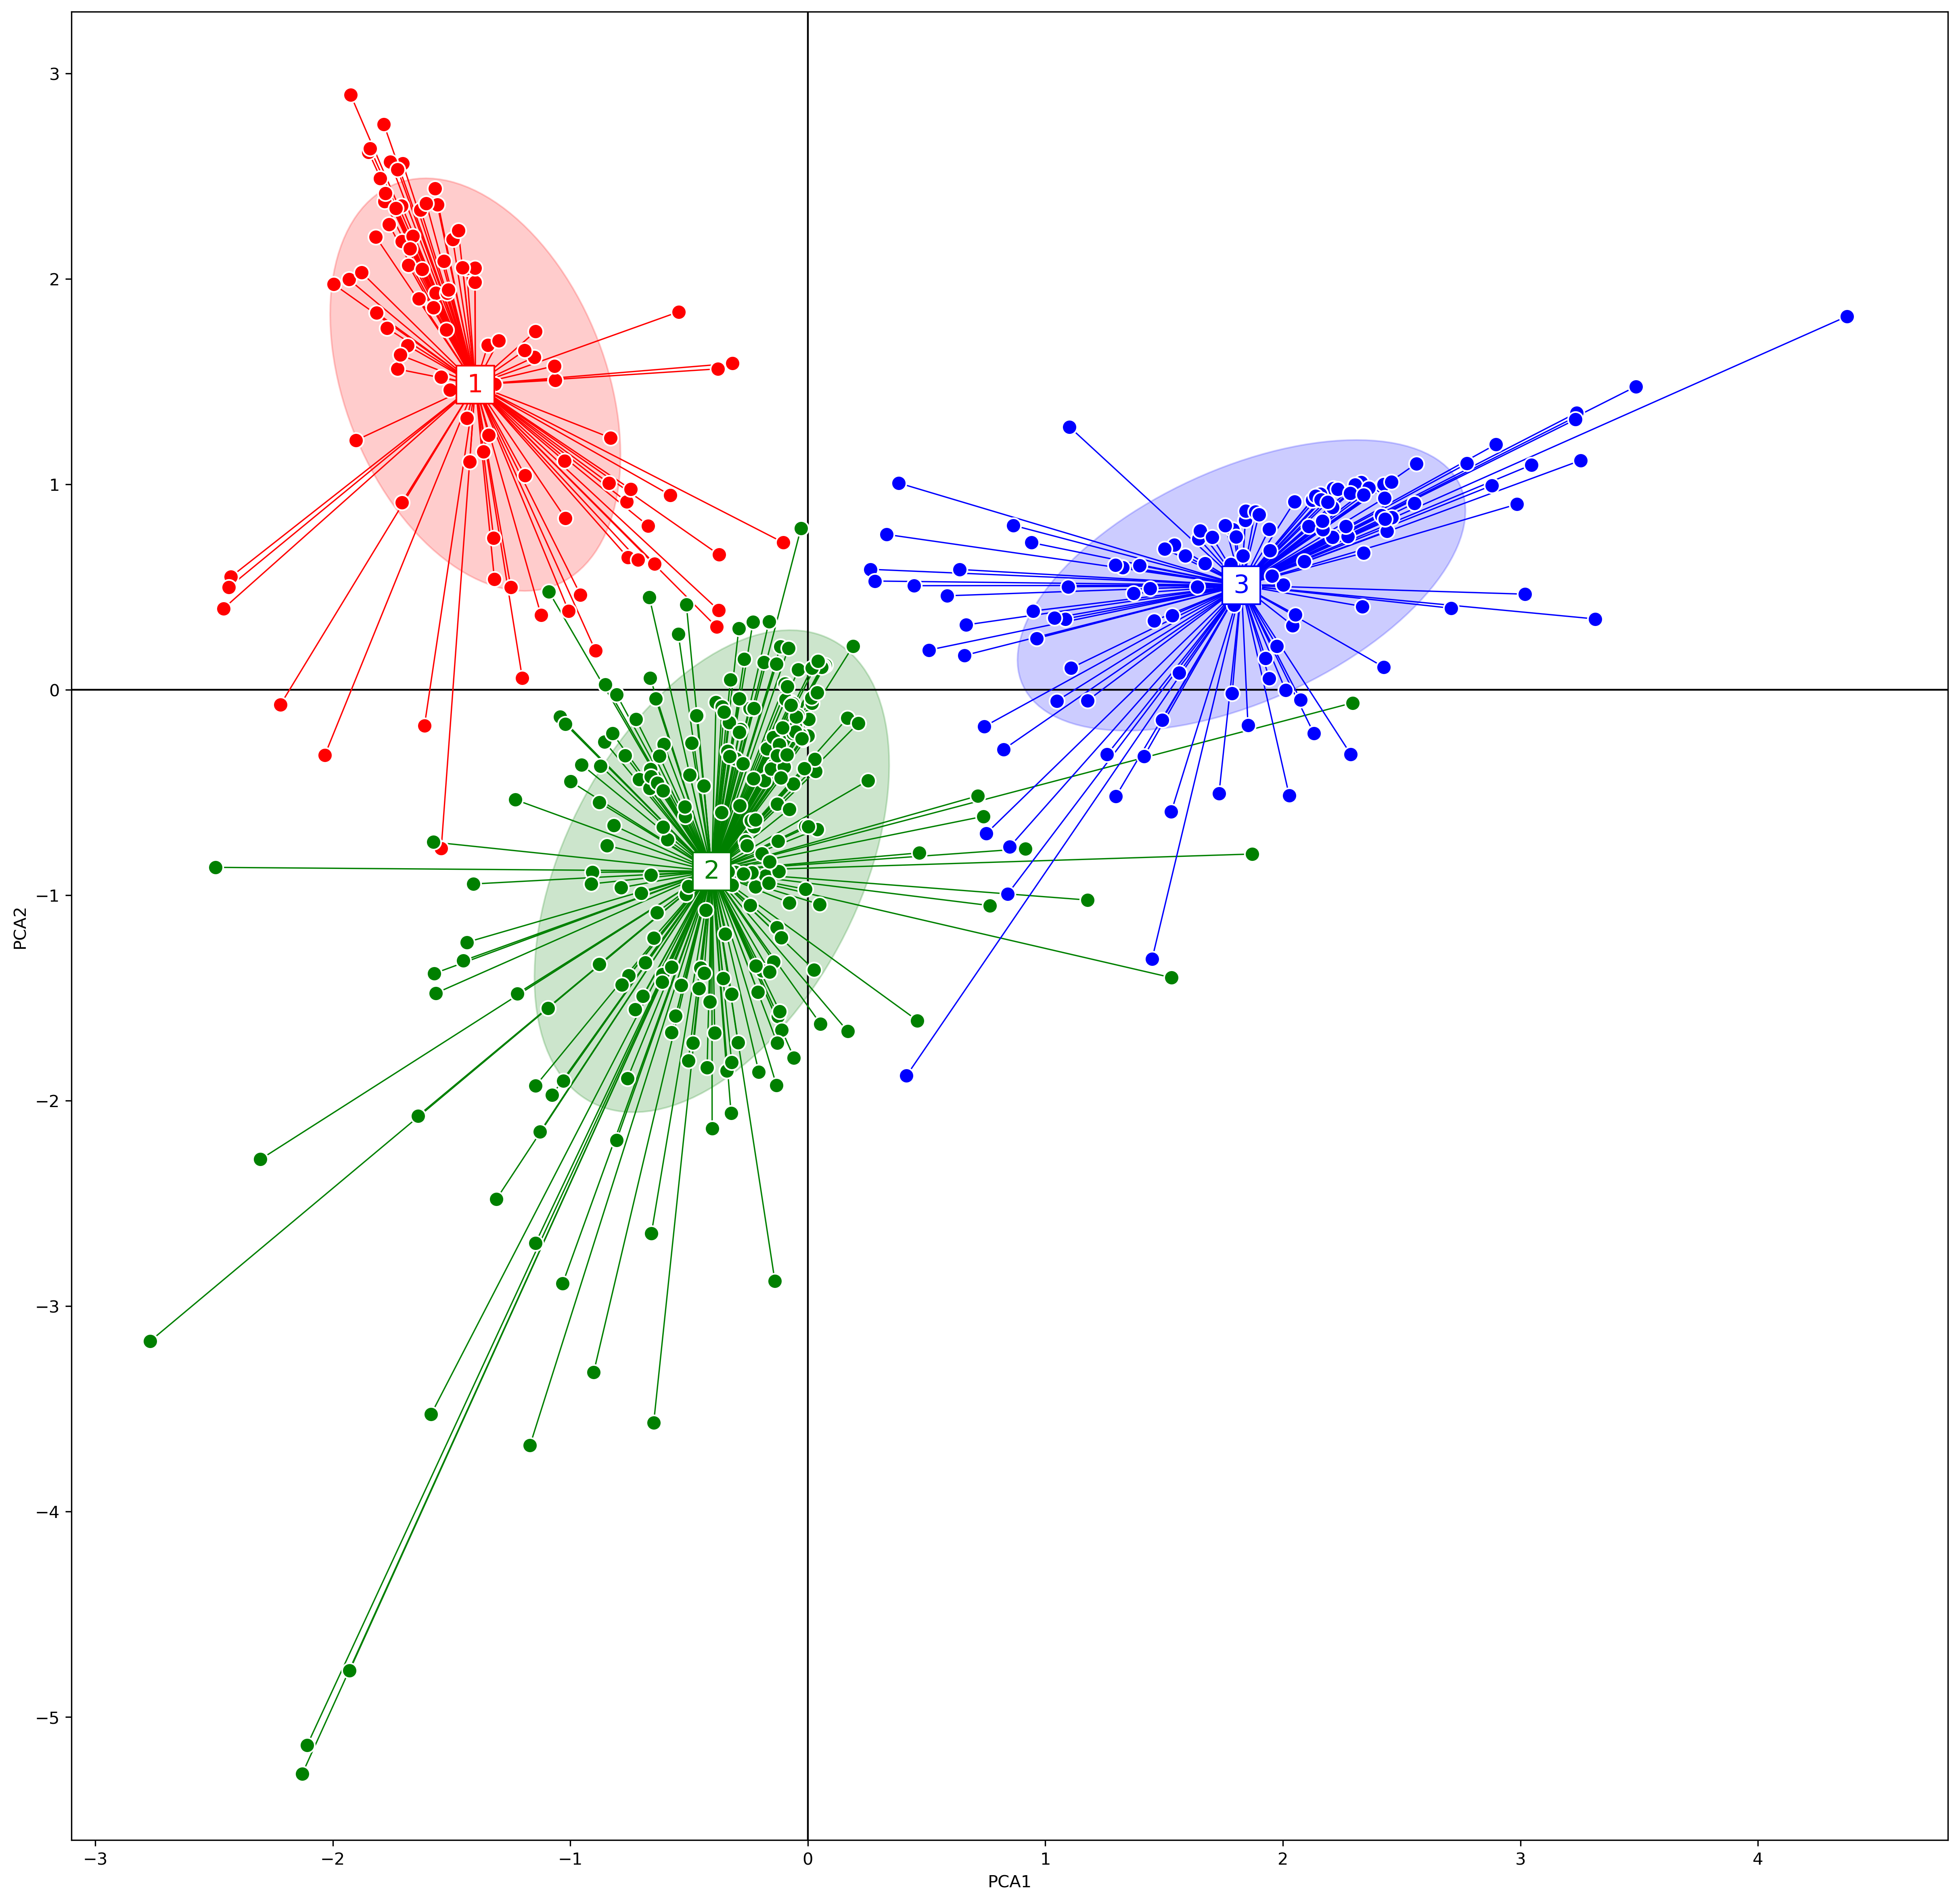

In [34]:
def plot_scatters(ax, x, y, color, marker, label, fontsize=18):
    _ = ax.vlines(x=0, ymin=-5.6, ymax=3.3, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.hlines(y=0, xmin=-3.1, xmax=4.8, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.scatter(x, y, marker=marker, lw=1, color=color, label=label, s=80, ec='white', zorder=7)
    centerx, centery = x.mean(), y.mean()
    _ = ax.scatter([centerx], [centery], lw=1, color='white', marker='s', s=500, ec=color, zorder=8)
    _ = ax.annotate(label, [centerx-0.035, centery-0.035], fontsize=15, color=color, zorder=9)
    for i in range(len(x)):
        _ = ax.plot([centerx, x[i]], [centery, y[i]], color=color, lw=0.8, zorder=6)
    _ = plot_ellipses(ax, x, y, std=1.25, facecolor=color, edgecolor=color, alpha=0.2)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax = plt.subplot(1,1,1)
plot_scatters(ax, pca.loc[cluster==1, 'CS1'], pca.loc[cluster==1, 'CS2'], 'r', 'o', '1', fontsize=18)
plot_scatters(ax, pca.loc[cluster==2, 'CS1'], pca.loc[cluster==2, 'CS2'], 'g', 'o', '2', fontsize=18)
plot_scatters(ax, pca.loc[cluster==3, 'CS1'], pca.loc[cluster==3, 'CS2'], 'b', 'o', '3', fontsize=18)
_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.xlim([-3.1, 4.8])
_ = plt.ylim([-5.6, 3.3])
fig.savefig('../Results_0609/5.3. 肠型_Child_pca.pdf', dpi=300)

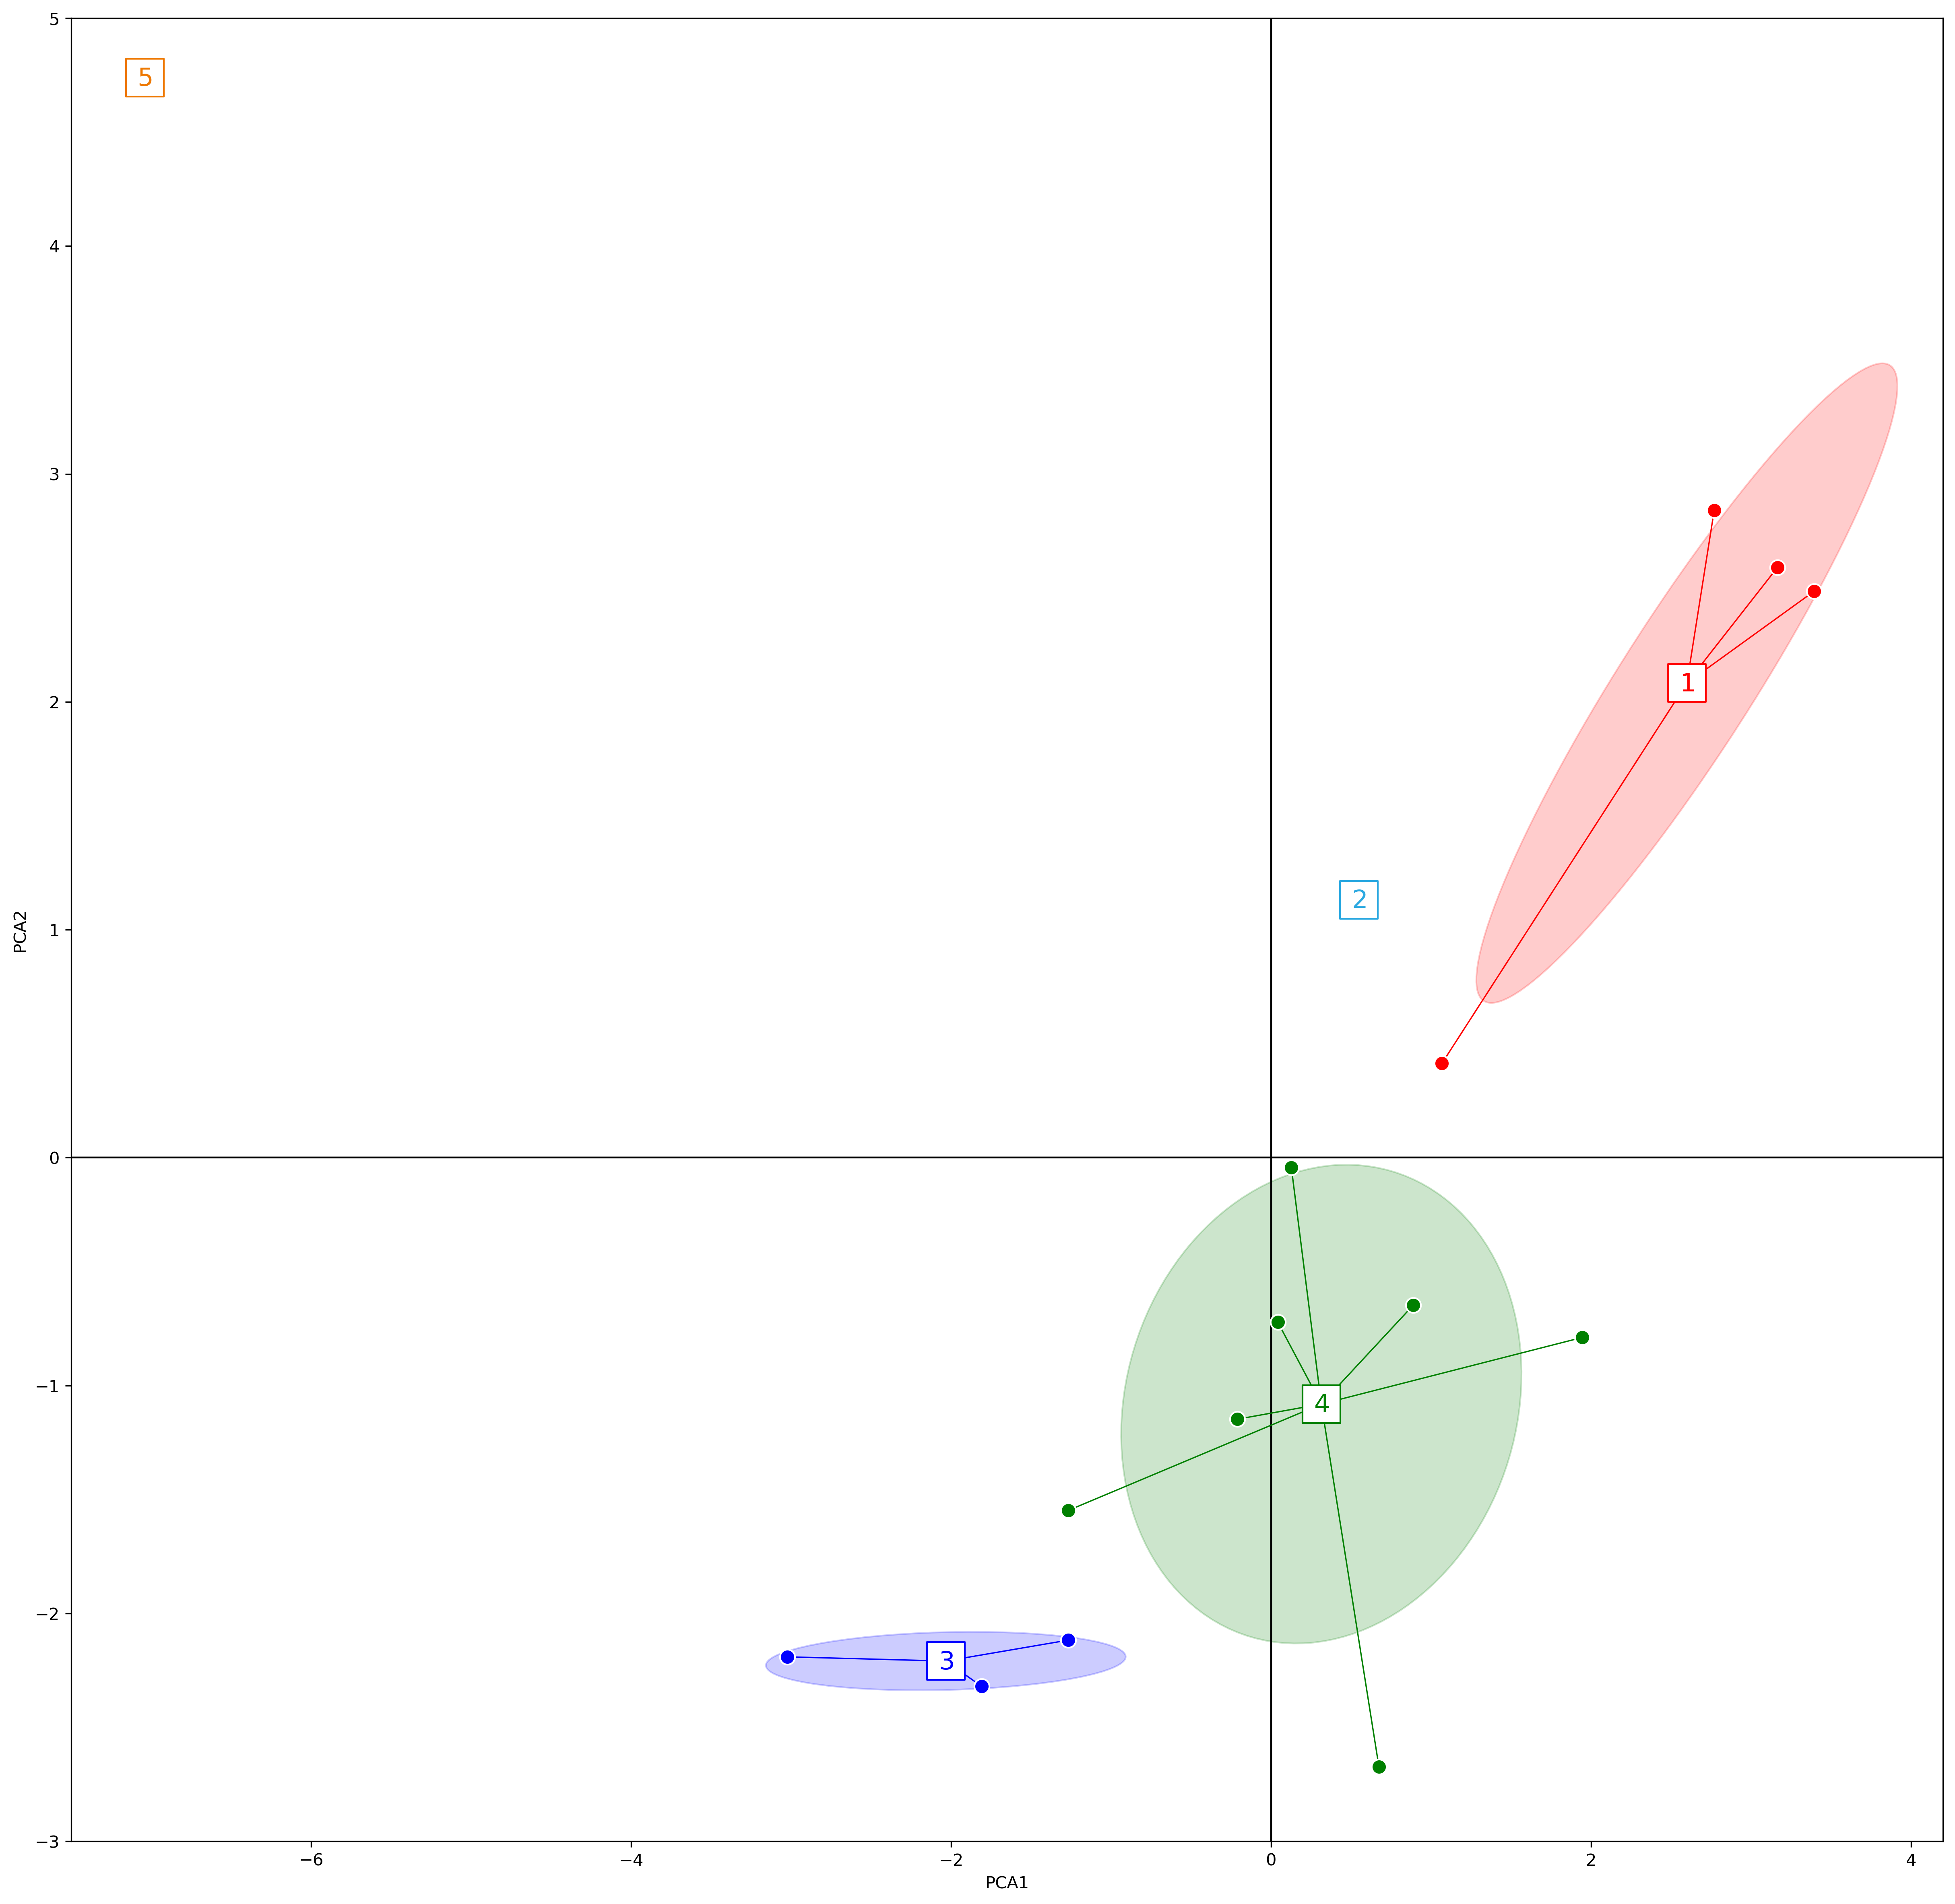

In [71]:
def plot_scatters(ax, x, y, color, marker, label, fontsize=18):
    _ = ax.vlines(x=0, ymin=-3, ymax=5, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.hlines(y=0, xmin=-7.5, xmax=4.2, lw=1, ls='-', color='k', zorder=-0)
    _ = ax.scatter(x, y, marker=marker, lw=1, color=color, label=label, s=80, ec='white', zorder=7)
    centerx, centery = x.mean(), y.mean()
    _ = ax.scatter([centerx], [centery], lw=1, color='white', marker='s', s=500, ec=color, zorder=8)
    _ = ax.annotate(label, [centerx-0.045, centery-0.035], fontsize=15, color=color, zorder=9)
    for i in range(len(x)):
        _ = ax.plot([centerx, x[i]], [centery, y[i]], color=color, lw=0.8, zorder=6)
    _ = plot_ellipses(ax, x, y, std=1.25, facecolor=color, edgecolor=color, alpha=0.2)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax = plt.subplot(1,1,1)
plot_scatters(ax, pca.loc[cluster==1, 'CS1'], pca.loc[cluster==1, 'CS2'], 'r', 'o', '1', fontsize=18)
plot_scatters(ax, pca.loc[cluster==3, 'CS1'], pca.loc[cluster==3, 'CS2'], 'b', 'o', '3', fontsize=18)
plot_scatters(ax, pca.loc[cluster==4, 'CS1'], pca.loc[cluster==4, 'CS2'], 'g', 'o', '4', fontsize=18)

_ = ax.scatter(pca.loc[cluster==2, 'CS1'], pca.loc[cluster==2, 'CS2'], lw=1, color='white', 
               marker='s', s=500, ec='#2ca9e1', zorder=8)
_ = ax.annotate('2', [pca.loc[cluster==2, 'CS1'][0]-0.045, pca.loc[cluster==2, 'CS2'][0]-0.035], 
                fontsize=15, color='#2ca9e1', zorder=9)

_ = ax.scatter(pca.loc[cluster==5, 'CS1'], pca.loc[cluster==5, 'CS2'], lw=1, color='white', 
               marker='s', s=500, ec='#ee7800', zorder=8)
_ = ax.annotate('5', [pca.loc[cluster==5, 'CS1'][0]-0.045, pca.loc[cluster==5, 'CS2'][0]-0.035], 
                fontsize=15, color='#ee7800', zorder=9)

_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.xlim([-7.5, 4.2])
_ = plt.ylim([-3, 5])
fig.savefig('../Results_0609/5.3. 肠型_Mom_pca.pdf', dpi=300)

# difference analysis

In [6]:
def diff_analysis_anova(data, groups):
    '''
    # data : data set with sample in index and item in columns
    # groups : 分组信息，numpy array
    # return : statistic table
    '''
    from scipy.stats import f_oneway
    import statsmodels.stats.multitest as multi
    statistics = []
    for item in data.columns:
        #stat, p = f_oneway(*[data.loc[groups==g, item] for g in set(groups)])
        try:
            stat, p_value = f_oneway(*[data.loc[groups==g, item] for g in set(groups)])
        except:
            f, p_value = 0, 1.0
        p_value = 1.0 if str(p_value)=='nan' else p_value
        statistics.append([item, set(groups), [list(groups).count(g) for g in set(groups)], 
                           [data.loc[groups==g, item].mean() for g in set(groups)], p_value])
    statistics = pd.DataFrame(statistics, index = data.columns, columns = ['ID', 'Groups', 'N', 'AveExpr','P.Value'])
    statistics['adj.P.Val'] = multi.multipletests(statistics['P.Value'], method = 'fdr_bh')[1]
    statistics = statistics.sort_values('P.Value')
    return statistics

In [62]:
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L2.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]

cluster = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
set(cluster['Cluster'])
statistics = diff_analysis_anova(data.loc[:, cluster.index].T, cluster['Cluster'].values)
statistics.to_csv('../Results_0609/5.3. 肠型_Child_diff_phylum.tsv', sep='\t')

{1, 2, 3}

In [67]:
data = pd.read_csv('../Data/16S/DADA2_table/MZJ_dada2_table_L6.tsv', sep='\t', index_col=0, skiprows=1)
data.columns = [i if i!='11_10' else 'C11_10' for i in data.columns]
data = data/data.sum()*100

cluster = pd.read_csv('../Results_0609/5.3. 肠型_Mom_pca.tsv', sep='\t', index_col=0)
set(cluster['Cluster'])
statistics = diff_analysis_anova(data.loc[:, cluster.index].T, cluster['Cluster'].values)
statistics.to_csv('../Results_0609/5.3. 肠型_Mom_diff_genus.tsv', sep='\t')

{1, 2, 3, 4, 5}

# Dynamic change

In [139]:
child_cluster = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
mom_cluster = pd.read_csv('../Results_0609/5.3. 肠型_Mom_pca.tsv', sep='\t', index_col=0)
Times = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 
         'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27']
child_cluster.head(2)
nodes = set()
links = set()
link_values = {}
for i in child_cluster.index:
    t = meta.loc[i, 'Time']
    #if t == 'T1':
    #    continue
    c = child_cluster.loc[i, 'Cluster']
    name = str(t)+'_C'+str(c)
    color = 'red' if c==1 else ('green' if c==2 else 'blue')
    nodes.add("{'name':'"+name+"','itemStyle': {'color':'"+color+"','borderColor':'white'},'label':{'show':false},'depth':"+t[1:]+"}")
for cid in set(meta.loc[meta['Sample_type']=='C', 'Child_ID']):
    samples = meta.loc[meta['Child_ID']==cid, ['Day', 'Time']].sort_values('Day')
    #cid, samples
    for i in range(0, samples.shape[0]-1): # 1 if samples['Time'][0]=='T1' else 0
        source = samples.index[i]
        target = samples.index[i+1]
        source_name = samples.loc[source, 'Time']+'_C'+str(child_cluster.loc[source, 'Cluster'])
        target_name = samples.loc[target, 'Time']+'_C'+str(child_cluster.loc[target, 'Cluster'])
        link_values[(source_name, target_name)] = link_values.get((source_name, target_name), 0) + 1
    # mom
    mid = meta.loc[samples.index[0], 'MotherID']
    if str(mid)!='nan':
        name = 'M_C'+str(mom_cluster.loc[mid, 'Cluster'])
        color = {1:'red', 3:'green', 4:'blue', 2:'deepskyblue', 5:'orange'}[mom_cluster.loc[mid, 'Cluster']]
        nodes.add("{'name':'"+name+"','itemStyle': {'color':'"+color+"','borderColor':'white'},'label':{'show':false},'depth':0}")
        target = samples.index[0] # samples.index[1] if samples['Time'][0]=='T1' else samples.index[0]
        target_name = samples.loc[target, 'Time']+'_C'+str(child_cluster.loc[target, 'Cluster'])
        link_values[(name, target_name)] = link_values.get((source_name, target_name), 0) + 1
    
'['+','.join(nodes)+']'
for (source, target) in link_values.keys():
    links.add("{'source':'"+source+"', 'target':'"+target+"', 'value':"+str(link_values[(source, target)])+"}")
'['+','.join(links)+']'


,CS1,CS2,Cluster
C11_10,-0.644567,0.613098,1
C11_11,-0.489394,-0.260424,2


"[{'name':'T20_C2','itemStyle': {'color':'green','borderColor':'white'},'label':{'show':false},'depth':20},{'name':'T16_C3','itemStyle': {'color':'blue','borderColor':'white'},'label':{'show':false},'depth':16},{'name':'T22_C3','itemStyle': {'color':'blue','borderColor':'white'},'label':{'show':false},'depth':22},{'name':'T20_C3','itemStyle': {'color':'blue','borderColor':'white'},'label':{'show':false},'depth':20},{'name':'M_C4','itemStyle': {'color':'blue','borderColor':'white'},'label':{'show':false},'depth':0},{'name':'T5_C2','itemStyle': {'color':'green','borderColor':'white'},'label':{'show':false},'depth':5},{'name':'T8_C1','itemStyle': {'color':'red','borderColor':'white'},'label':{'show':false},'depth':8},{'name':'T24_C3','itemStyle': {'color':'blue','borderColor':'white'},'label':{'show':false},'depth':24},{'name':'T10_C2','itemStyle': {'color':'green','borderColor':'white'},'label':{'show':false},'depth':10},{'name':'T9_C2','itemStyle': {'color':'green','borderColor':'white'

"[{'source':'T17_C2', 'target':'T19_C3', 'value':1},{'source':'T12_C3', 'target':'T13_C3', 'value':3},{'source':'T14_C2', 'target':'T15_C2', 'value':7},{'source':'T6_C1', 'target':'T8_C1', 'value':1},{'source':'M_C4', 'target':'T2_C2', 'value':1},{'source':'T26_C1', 'target':'T27_C2', 'value':1},{'source':'T20_C1', 'target':'T22_C2', 'value':1},{'source':'T11_C3', 'target':'T12_C3', 'value':2},{'source':'T24_C3', 'target':'T25_C3', 'value':4},{'source':'T19_C3', 'target':'T20_C3', 'value':3},{'source':'T12_C2', 'target':'T13_C3', 'value':1},{'source':'T6_C2', 'target':'T7_C2', 'value':8},{'source':'T4_C1', 'target':'T5_C1', 'value':6},{'source':'T9_C2', 'target':'T10_C1', 'value':1},{'source':'T3_C3', 'target':'T4_C2', 'value':1},{'source':'T12_C1', 'target':'T13_C2', 'value':1},{'source':'T10_C3', 'target':'T11_C3', 'value':3},{'source':'T12_C3', 'target':'T13_C2', 'value':1},{'source':'T6_C1', 'target':'T7_C2', 'value':1},{'source':'T8_C1', 'target':'T9_C1', 'value':5},{'source':'T9_

# Functional difference

In [60]:
child_cluster = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
data = pd.read_csv('../Data/16S/picrust2_out_pipeline/pathways_out/path_abun_unstrat.tsv', sep='\t', index_col=0)
data.columns = ['C11_10' if i=='11_10' else i for i in data.columns]
data.shape
data.head(2)

pathways = pd.read_csv('../Data/16S/picrust2_out_pipeline/pathways_out/metacyc_pathways_info.txt', sep='\t', index_col=0, header=None)

anno = pd.read_csv('../Data/16S/picrust2_out_pipeline/pathways_out/MetaCYC_annotation.tsv', sep='\t', index_col=0)
anno = anno.loc[data.index, :]
anno = anno.drop_duplicates()
anno.shape

level2pathway = {}
pathway2level = {}
for i in set(data.index):
    if type(anno.loc[i, 'Annotation'])!=str:
        levels = []
        for j in anno.loc[i, 'Annotation']:
            levels.append(j.split(';'))
    else:
        levels = [anno.loc[i, 'Annotation'].split(';')]
    for j in levels:
        if j[1].strip()=='L_2__Superpathways':
            continue
        level2pathway[j[2]] = level2pathway.get(j[2], set())
        level2pathway[j[2]].add(i)
        pathway2level[i] = j[2]
len(level2pathway)

(412, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
pathway,,,,,,,,,,,,,,,,,,,,,
1CMET2-PWY,10060.919209,6611.960926,12429.300543,11143.305746,21296.739095,16342.105287,15632.713319,6301.17746,11131.373797,22650.873480,...,9710.866291,10077.298691,9355.237385,7216.053727,5728.952011,23369.157159,6161.975489,5675.748014,12025.493906,10646.625483
3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,7952.820740,65.199695,57.754489,362.935135,49.717529,0.000000,209.220207,0.00000,21.633023,15.620458,...,0.000000,0.000000,0.000000,0.000000,0.000000,183.049957,1168.350596,0.000000,0.000000,13.650455


(676, 2)

58

In [43]:
path_statistics = diff_analysis_anova(data.loc[:, child_cluster.index].T, child_cluster['Cluster'].values)
path_statistics.to_csv('../Results_0609/5.3. 肠型_Pathway_diff.tsv', sep='\t')

In [44]:
path_statistics.head(2)

,ID,Groups,N,AveExpr,P.Value,adj.P.Val
pathway,,,,,,
PWY-7323,PWY-7323,"{1, 2, 3}","[95, 231, 124]","[1029.8929352233765, 1686.7914795088955, 11551...",4.025329e-96,1.658435e-93
COLANSYN-PWY,COLANSYN-PWY,"{1, 2, 3}","[95, 231, 124]","[1265.23518669201, 2238.049861361146, 7972.977...",6.691500e-90,1.378449e-87


In [69]:
data_level = pd.DataFrame(columns=data.columns)
for level, paths in level2pathway.items():
    data_level.loc[level, :] = data.loc[paths, :].sum().values
data_level_rel = data_level/data_level.sum()*100
path_order = data_level_rel.mean(1).sort_values(ascending=False).index
path_order[:3]
top = 15
colors = ['#e60033', '#ee7800', '#ffd900', '#3eb370', '#0095d9', '#165e83', '#884898', 
          '#efab93', '#f8e58c', '#e0c38c', '#7ebea5', '#4d5aaf', '#d7cf3a', '#dcd3b2',
          '#e17b34', '#6f4b3e']

Index(['L_3__Amino Acid Biosynthesis',
       'L_3__Cofactor, Prosthetic Group, Electron Carrier, and Vitamin Biosynthesis',
       'L_3__Nucleoside and Nucleotide Biosynthesis'],
      dtype='object')

In [45]:
points = path_statistics['AveExpr'].values.copy()
for i in range(len(points)):
    points[i] = np.array(points[i])/sum(points[i])*100

In [81]:
colormap = []
for i in path_statistics.index:
    pclass = pathway2level.get(i, 'None')
    if pclass in path_order[:top]:
        colormap.append(colors[list(path_order).index(pclass)])
    else:
        colormap.append('#c0c6c9')

In [108]:
mean_abun.min(), mean_abun.max()

(0.029705490634117687, 59100.27230287281)

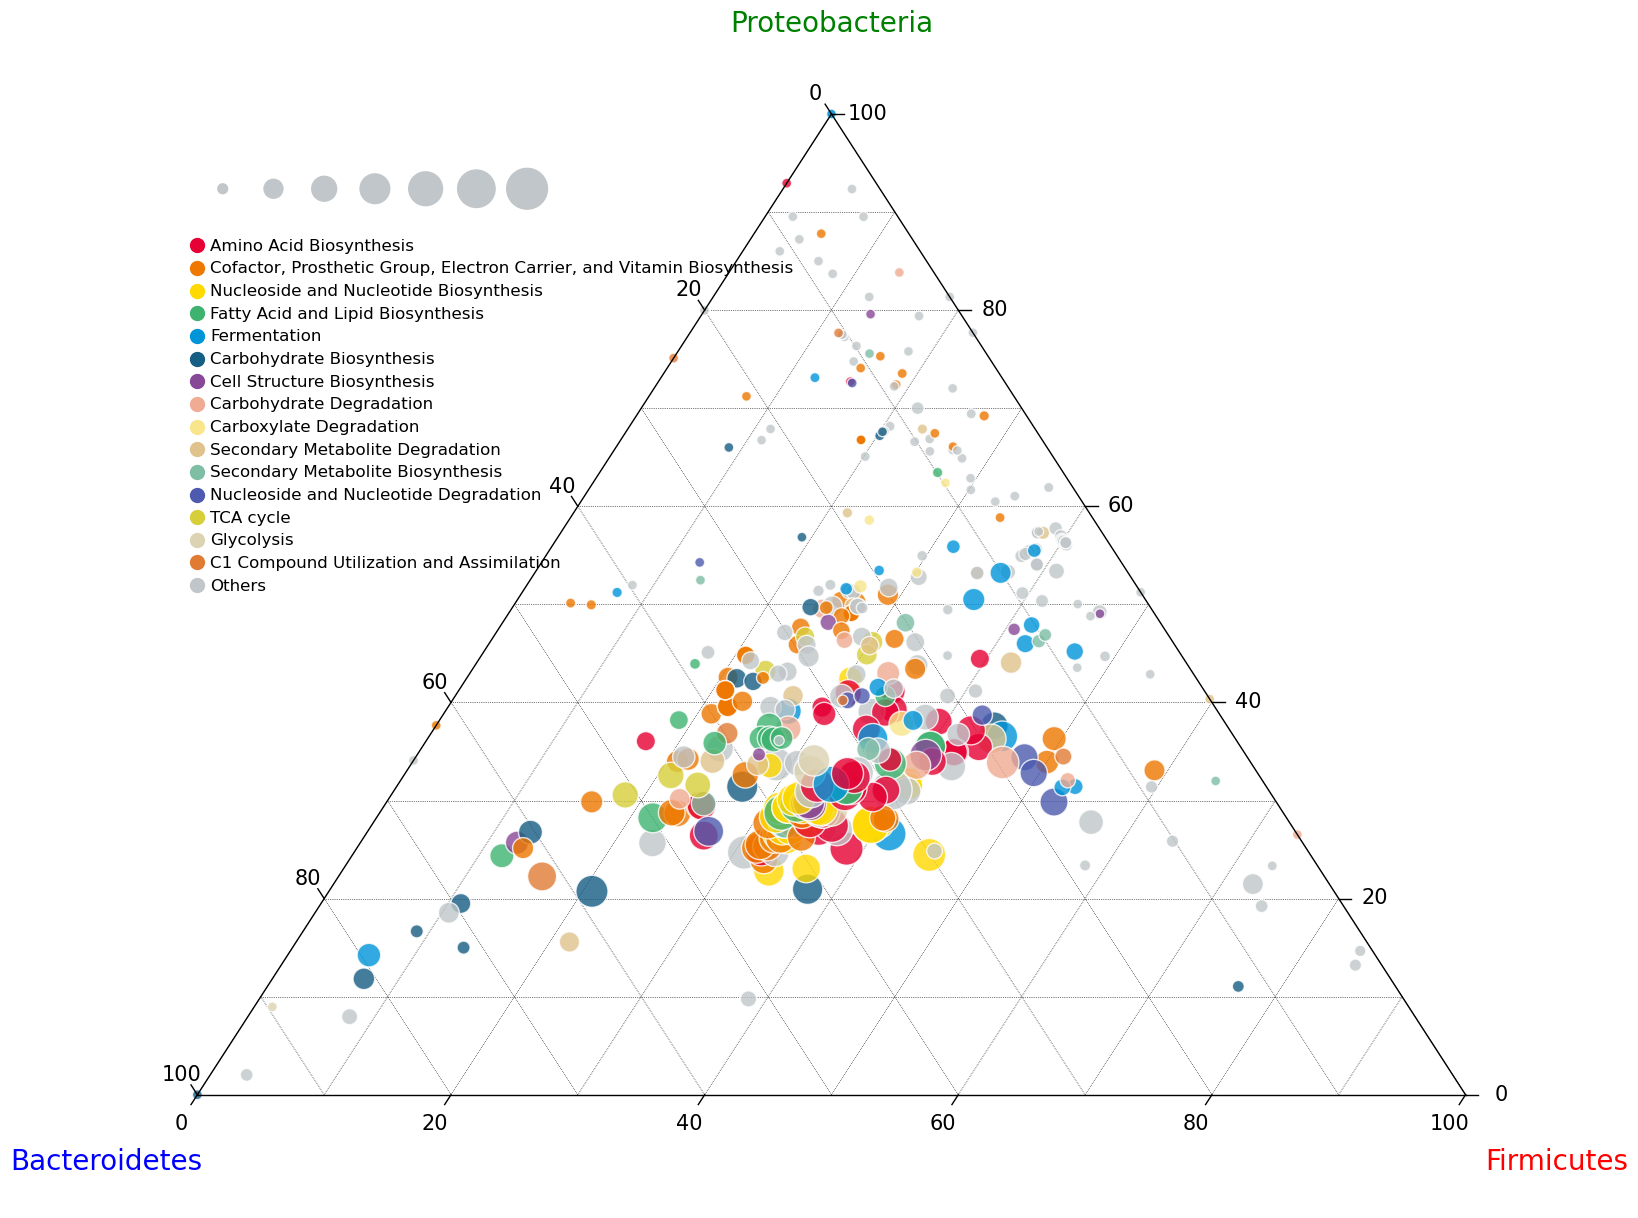

In [125]:
labels = ['Proteobacteria', 'Firmicutes', 'Bacteroidetes']
mean_abun = np.array([np.sum(i) for i in path_statistics['AveExpr'].values])
size = 50 + mean_abun/max(mean_abun)*800

import ternary
fig, ax = plt.subplots(figsize=(18, 15), dpi=100)
scale = 100
fig, tax = ternary.figure(ax=ax, scale=scale)

# Draw Boundary and Gridlines
_ = tax.boundary(linewidth=1.0)
_ = tax.gridlines(color="k", multiple=10, linewidth=0.5, zorder=-10)

# Set Axis labels and Title
_ = tax.top_corner_label(labels[0], fontsize=20, color='green')
_ = tax.right_corner_label(labels[1], fontsize=20, color='red')
_ = tax.left_corner_label(labels[2], fontsize=20, color='blue')

# Scatter
_ = tax.scatter(points, s=size, marker='o', color=colormap, linewidths=1, edgecolors='white', alpha=0.8)
    
_ = tax.ticks(axis='lbr', multiple=20, linewidth=1, fontsize=15)
_ = tax.set_background_color('white')
_ = tax.get_axes().axis('off')
#plt.title(title)
#_ = tax.show()

legend_size = [50 + i/max(mean_abun)*800 for i in [0, 10000, 20000, 30000, 40000, 50000, 60000]]
_ = plt.scatter([2, 6, 10, 14, 18, 22, 26], [80, 80, 80, 80, 80, 80, 80], c='#c0c6c9', s=legend_size)
h = 75
for i in path_order[:top]:
    _ = plt.scatter([0], [h], c=colors[list(path_order).index(i)], s=100)
    _ = plt.annotate(i.split('__')[1], [1, h-0.4], fontsize=12)
    h -= 2
_ = plt.scatter([0], [h], c='#c0c6c9', s=100)
_ = plt.annotate('Others', [1, h-0.4], fontsize=12)
fig.savefig('../Results_0609/5.3. 肠型_Pathway_diff.pdf', dpi=300)

# Enterotypes vs. clinical factors

In [128]:
cluster = pd.read_csv('../Results_0609/5.3. 肠型_Child_pca.tsv', sep='\t', index_col=0)
cluster['Gender'] = meta.loc[cluster.index, 'Gender']
cluster['DeliveryMode'] = meta.loc[cluster.index, 'Mode of delivery']
cluster['Sibling'] = meta.loc[cluster.index, 'Sibling(Y:1,N:0)']
cluster['SolidFood'] = meta.loc[cluster.index, 'Solid food']
cluster['BreastFeeding'] = meta.loc[cluster.index, 'Breastfeeding']
cluster['FeedingMode'] = meta.loc[cluster.index, 'Feeding mode(BFD:0,MFD:1)']
cluster['PAE'] = meta.loc[cluster.index, 'PAE(Y:1,N:0)']
cluster['Allergy'] = meta.loc[cluster.index, 'Allergy(Y:1,N:0)']
cluster.head(2)

,CS1,CS2,Cluster,Gender,DeliveryMode,Sibling,SolidFood,BreastFeeding,FeedingMode,PAE,Allergy
C11_10,-0.644567,0.613098,1,Female,C-section,0.0,0.0,1.0,0.0,0.0,1.0
C11_11,-0.489394,-0.260424,2,Female,C-section,0.0,0.0,1.0,0.0,0.0,1.0


In [136]:
from scipy.stats import kendalltau
result = []
for index in ['Gender', 'DeliveryMode', 'Sibling', 'SolidFood', 'BreastFeeding', 'FeedingMode', 'PAE', 'Allergy']:
    temp = cluster[[index, 'Cluster']].dropna()
    x = temp['Cluster'].values
    y = temp[index].values
    r0, p0 = kendalltau(x, y)
    pval = 1
    for i in range(999):
        np.random.shuffle(y)
        r, _ = kendalltau(x, y)
        if (r0<0 and r<=r0) or (r0>=0 and r>=r0):
            pval += 1
    pval = pval/1000.
    result.append([index, r0, p0, pval])
    index, r0, pval
result = pd.DataFrame(result, columns=['Index', 'KendallTau', 'p0', 'P-value'])

('Gender', -0.1730898677459219, 0.001)

('DeliveryMode', 0.44523616664167737, 0.001)

('Sibling', 0.03598000752963106, 0.225)

('SolidFood', 0.23958314043244192, 0.001)

('BreastFeeding', -0.07914257021169926, 0.048)

('FeedingMode', 0.1723856385002942, 0.001)

('PAE', 0.08113433035001397, 0.031)

('Allergy', -0.1635280908437163, 0.001)

In [139]:
result.to_csv('../Results_0609/5.3. 肠型_临床相关分析.tsv', sep='\t')

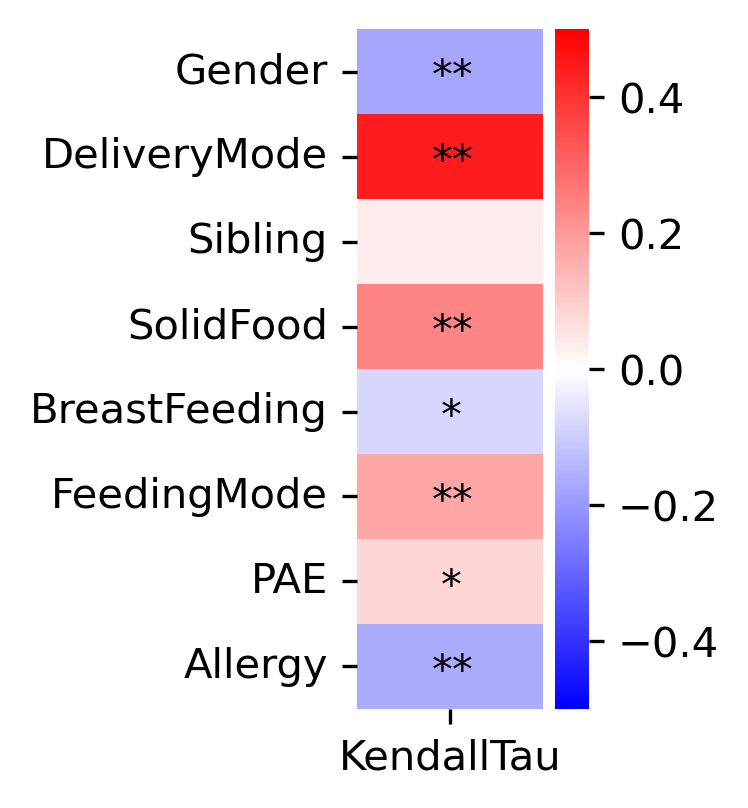

In [197]:
fig = plt.figure(figsize=(1, 3), dpi=300)
ax = plt.subplot(1,1,1)
_ = sns.heatmap(result[['KendallTau']], cmap='bwr', vmin=-0.5, vmax=0.5)
_ = ax.set_yticklabels(['Gender', 'DeliveryMode', 'Sibling', 'SolidFood', 'BreastFeeding', 'FeedingMode', 
                        'PAE', 'Allergy'], rotation=0)
for i in range(result.shape[0]):
    p = result['P-value'][i]
    marker = '**' if p<0.01 else ('*' if p<0.05 else '')
    x_ = 0.4 if p<0.01 else 0.45
    _ = ax.annotate(marker, (0+x_, i+0.7))
fig.savefig('../Results_0609/5.3. 肠型_临床相关分析.pdf', dpi=300)

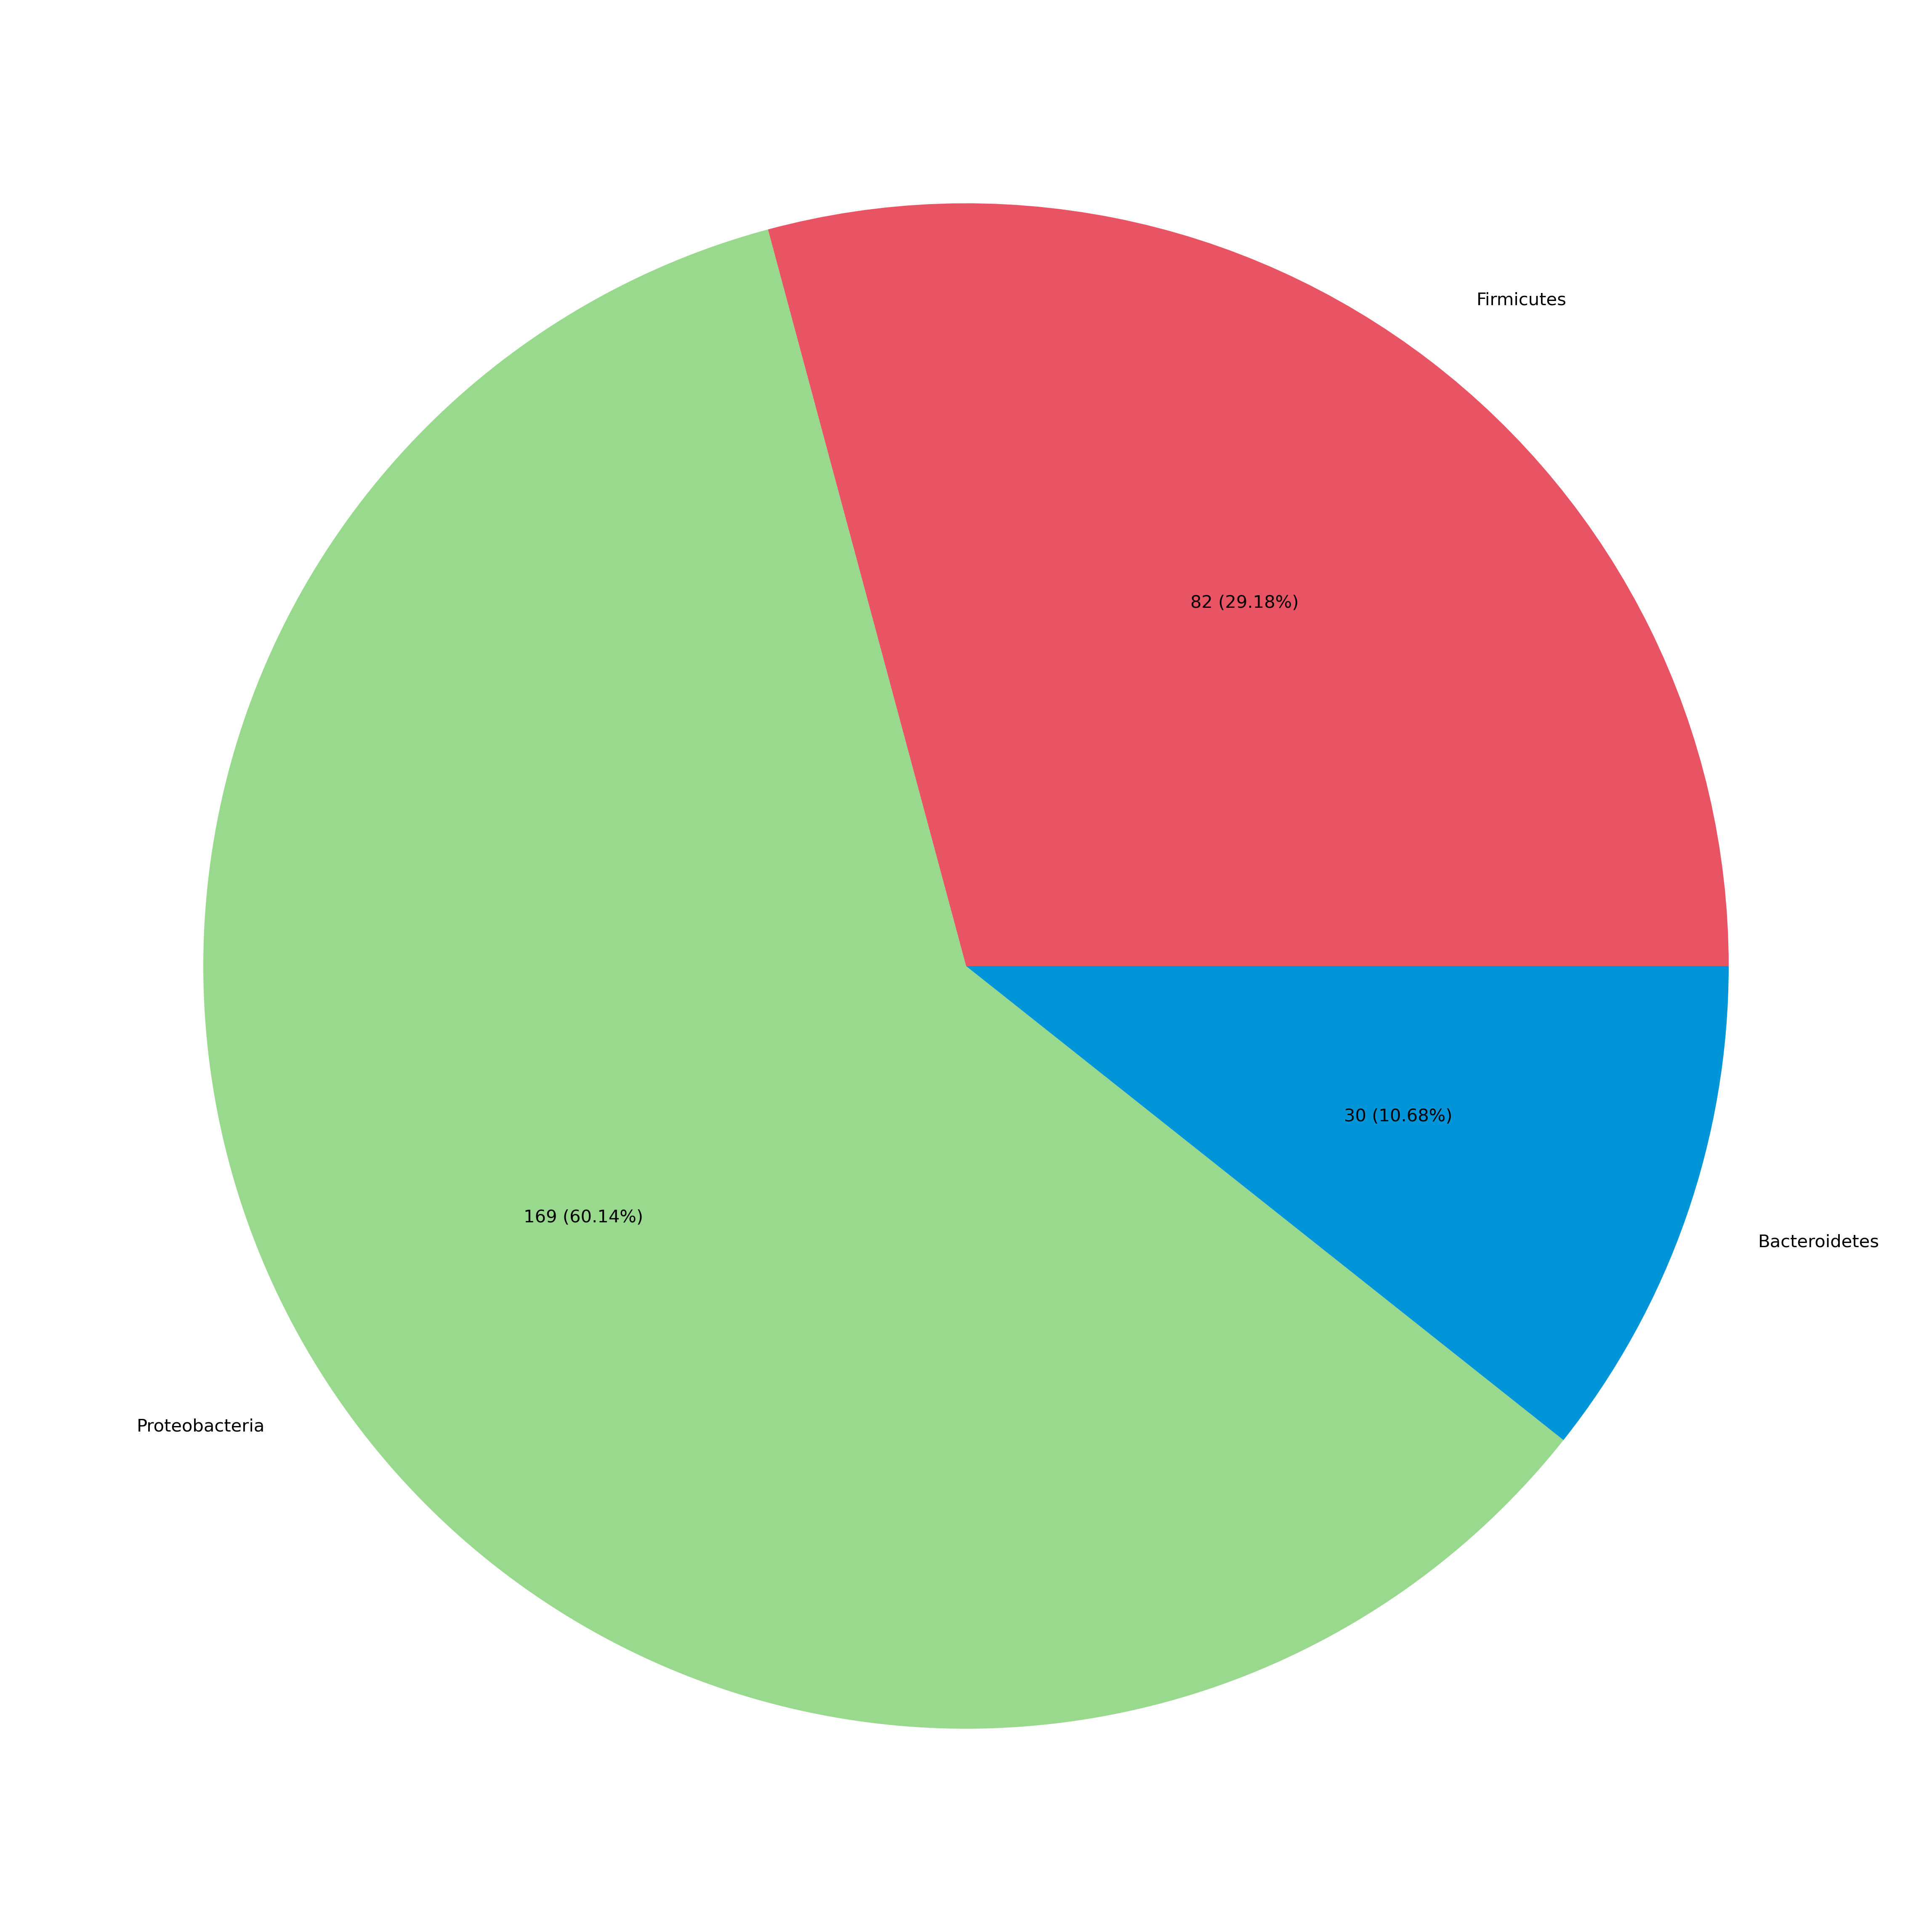

In [161]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(p=pct, v=val)
    return my_autopct

subtype = list(cluster.loc[cluster['DeliveryMode']=='C-section', 'Cluster'])
values = [subtype.count(i) for i in [1, 2, 3]]
fig = plt.figure(figsize=(20, 20), dpi=300)
_ = plt.pie(values, labels=['Firmicutes', 'Proteobacteria', 'Bacteroidetes'], pctdistance=0.6, labeldistance=1.1, 
            colors=['#e95464', '#98d98e', '#0095d9'], rotatelabels=False, autopct=make_autopct(values))
fig.savefig('../Results_0609/5.3. 肠型_临床相关分析_DeliveryMode(C-section).pdf', dpi=300)

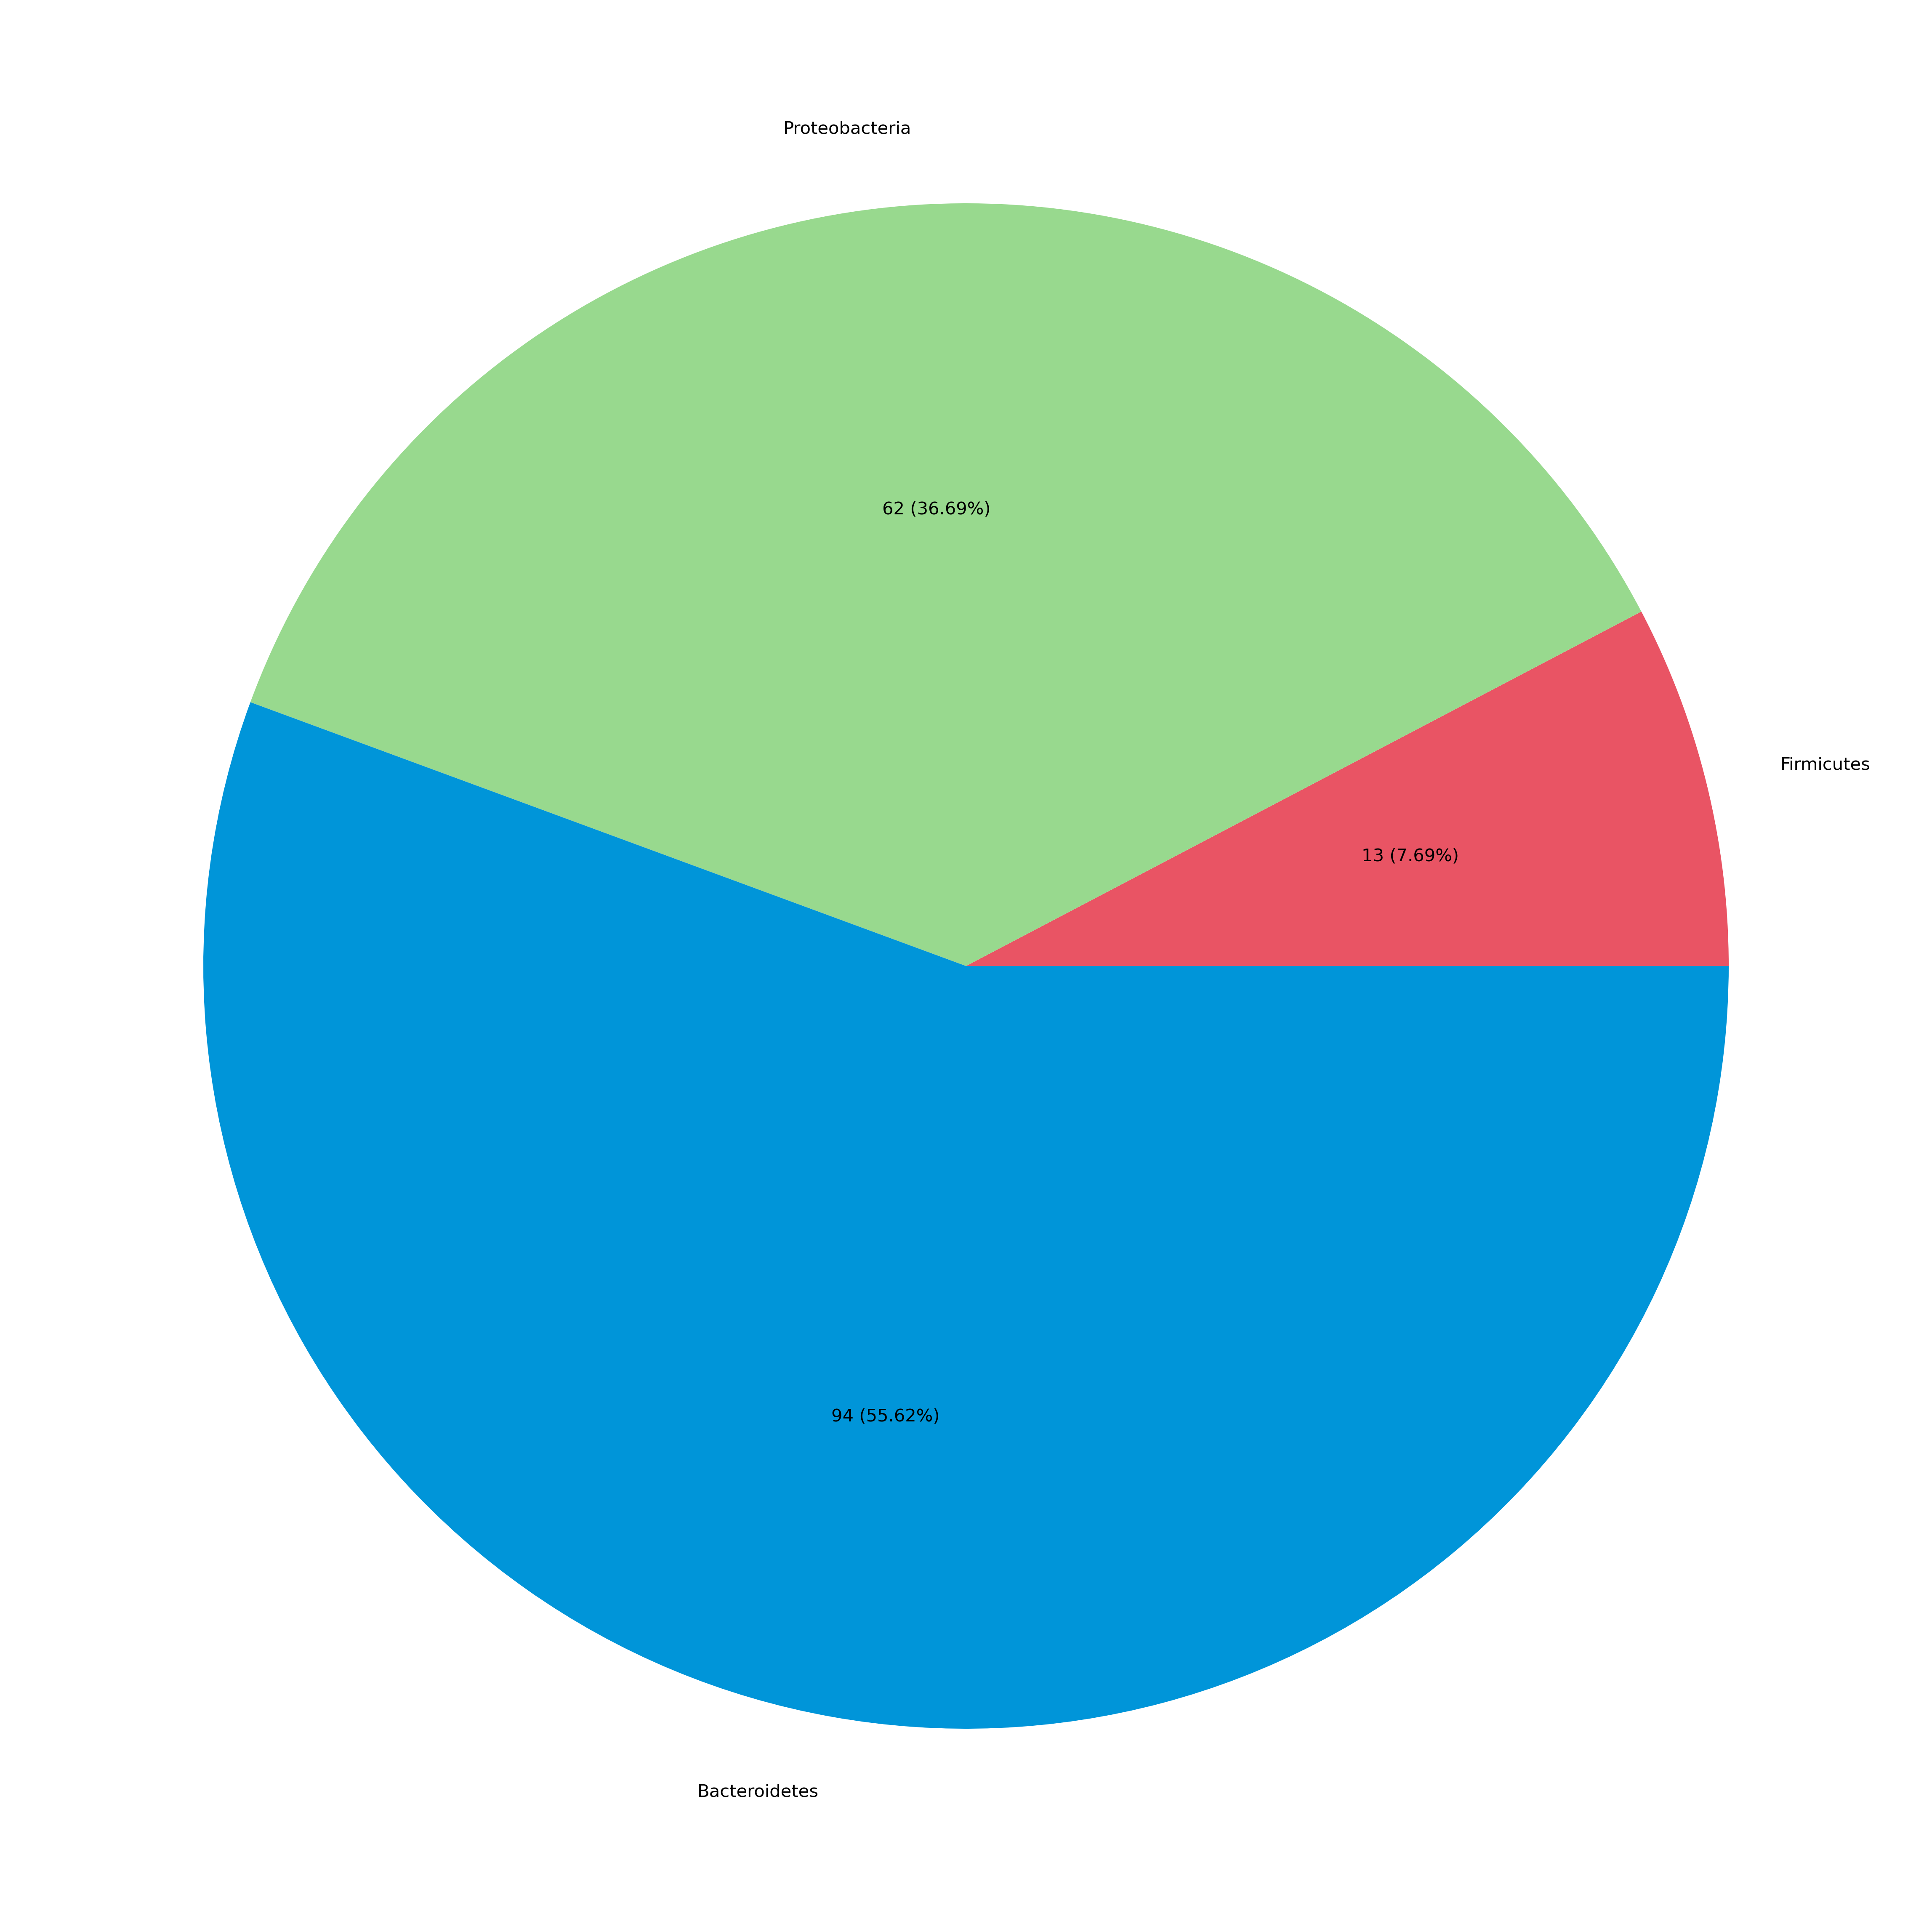

In [163]:
subtype = list(cluster.loc[cluster['DeliveryMode']!='C-section', 'Cluster'])
values = [subtype.count(i) for i in [1, 2, 3]]
fig = plt.figure(figsize=(20, 20), dpi=300)
_ = plt.pie(values, labels=['Firmicutes', 'Proteobacteria', 'Bacteroidetes'], pctdistance=0.6, labeldistance=1.1, 
            colors=['#e95464', '#98d98e', '#0095d9'], rotatelabels=False, autopct=make_autopct(values))
fig.savefig('../Results_0609/5.3. 肠型_临床相关分析_DeliveryMode(Vaginal).pdf', dpi=300)